In [1]:
import os
os.chdir('../')

In [2]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import random

from main import parse_args_and_config, Diffusion
from datasets import inverse_data_transform

import random, numpy as np, torch, torchvision.utils as vutils
import matplotlib.pyplot as plt

###############################################################################
# 1) 시드 고정
###############################################################################
SEED = 2025
random.seed(SEED)                 # 파이썬 random
np.random.seed(SEED)              # NumPy
torch.manual_seed(SEED)           # CPU 연산
torch.cuda.manual_seed_all(SEED)  # CUDA 연산 (여러 GPU도 한꺼번에)
torch.backends.cudnn.deterministic = True  # 가능하면 완전 결정론
torch.backends.cudnn.benchmark = False

###############################################################################
# 1) Notebook에서 sys.argv를 직접 설정 (argparse 흉내)
###############################################################################
sys.argv = [
    "main.py",
    "--config", "imagenet64.yml",  # 사용하려는 config
    "--sample",
    "--sample_type", "dpmsolver++",
    "--dpm_solver_type", "dpmsolver",
    "--dpm_solver_method", "multistep",
    "--dpm_solver_order", "3",
    "--timesteps", "8",
    "--skip_type", "logSNR",
    "--ni"
]

###############################################################################
# 2) 인자/설정 로드
###############################################################################
args, config = parse_args_and_config()

###############################################################################
# 3) Diffusion 객체 생성 -> 모델 로딩
###############################################################################
diffusion = Diffusion(args, config, rank=0)
diffusion.prepare_model()
diffusion.model.eval()
print('done')

2025-04-25 21:00:59.875603: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-25 21:00:59.895522: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-25 21:00:59.895548: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-25 21:00:59.896453: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-25 21:00:59.901000: I tensorflow/core/platform/cpu_feature_guar

[prepare_model] Model is ready.
done


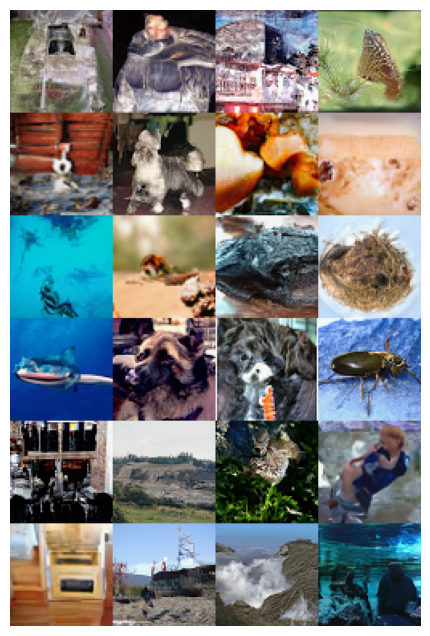

In [3]:
###############################################################################
# 2) 초기 노이즈 (여기서는 직접 NumPy→Torch 변환하지 말고,
#               Torch에서 바로 뽑으면 device 전송·복사 비용이 줄어듭니다)
###############################################################################
nrows = 4
ncols = 6
num_class = 200
num_samples = nrows*ncols
device = diffusion.device
g = torch.Generator(device=device).manual_seed(SEED)   # 개별 제너레이터

x = torch.randn(
        num_samples,
        config.data.channels,
        config.data.image_size,
        config.data.image_size,
        generator=g,
        device=device,
        dtype=torch.float32,
    )

###############################################################################
# 3) 샘플링
###############################################################################
sampled_x, _ = diffusion.sample_image(x, diffusion.model)

# [-1,1] → [0,1]
sampled_x = inverse_data_transform(config, sampled_x)

###############################################################################
# 4) 5×5 그리드(여백 0) 시각화
###############################################################################
grid = vutils.make_grid(sampled_x, nrow=nrows, padding=0)
grid_np = grid.permute(1, 2, 0).cpu().numpy()
grid_np = np.clip(grid_np, 0, 1)

plt.figure(figsize=(8, 8))
plt.imshow(grid_np)
plt.axis("off")
plt.show()
